In [80]:
import pandas as pd
import json
from evaluation_utils import read_global_results, ssl_method_to_category, unpivot_ssl_model, unpivot_baseline_model, read_processed_shards
from constants import RESULTS_ROOT, PRELIMINARY_DIR, MODE_1_PROCESSED_DIR, MODE_2_3_MARG_PROCESSED_DIR, TEST_METRIC, ENCODERS, TRAINING_SCHEMES, SSL_MODELS, BASELINES, ENCODER_COLORS, SINGLE_ENCODER_MODELS, \
                        GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL, MODE_1_LEARNING_CURVES_DIR, model_abbreviations
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from matplotlib.ticker import PercentFormatter
import itertools
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib import patches
from matplotlib.colors import ListedColormap
from itertools import zip_longest
from os.path import join
from sklearn.manifold import TSNE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)


In [2]:
df = read_processed_shards(MODE_2_3_MARG_PROCESSED_DIR)

1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
8.ndjson
9.ndjson
10.ndjson
11.ndjson
12.ndjson
13.ndjson
14.ndjson
15.ndjson
16.ndjson
17.ndjson
18.ndjson
19.ndjson
20.ndjson
21.ndjson
22.ndjson
23.ndjson
24.ndjson
25.ndjson
26.ndjson
27.ndjson
28.ndjson
29.ndjson
30.ndjson
31.ndjson
32.ndjson
concatenating
1.ndjson
2.ndjson
3.ndjson
concatenating


In [3]:
# SSL results
df_ssl = unpivot_ssl_model(df=df, suffix=TEST_METRIC, ssl_models=SSL_MODELS, encoders=ENCODERS, training_schemes=TRAINING_SCHEMES,  include_graph_params=True)
df_baseline = unpivot_baseline_model(df=df, suffix=TEST_METRIC, baseline_models=BASELINES, training_schemes=TRAINING_SCHEMES, include_graph_params=True)

## Appendix plots
#### For all graph paramters:
- The fixed parameters seems to make the default graphs harder than the graphs sampled for the global results. This is most obvious in the parameters which seem to have little influence on performance, such as cluster_size_slope, where most points on the line is below the results reported in the global results table.
- Comment on baselines for each graph parameter

#### Avg degree:
- Encoders:
    - The performance of GCN and GIN gets worse with higher avg degree no matter the training scheme for most SSL methods. This is also the case for GAT URL
    - For GAT trained wth JL or PF, most models either maintain their performance or increase it with higher avg degree. GAT generally performs best for higher degrees.
- Training schemes:
    - Most models seem to prefer JL or PF in the overall case (as seen in global)
    - There is generally not a big difference in how the avg degree affects the training schemes, but with (GAT, URL) we see that the performance degrades with higher degrees while GAT with JL or PF generally improves the performance 
- Specific observations for methods / categories:
    - CFR is one method that across all encoders prefer the URL training scheme. Interestingly (URL, GIN) has a very strong performance for low degrees, indicating that for some graphs a GIN encoder may be preferred. However, GAT takes over for higher degrees even for this method.
    - Methods that use PPR diffusion on the augmentated graphs are generally much less affected by the avg degree. In addition, these methods are the only ones where the performance of the GCN encoders increase when the degree is higher. This could suggest that topology augmentations that utilize diffusion strategies to add edges with a contrastive loss, are generally robust, but perform even better if the original graph has more edges. 
    - MVMI-FT does not seem to be affected by the avg degree at all. It is hard to pinpoint why this is the case, as this is by far the most complex method with many possible interactions. As MVMI-FT is always top performing no matter the avg degree, it suggests that it is robust to the amount of edges in the graph.

/tmp/ipykernel_34217/3650956971.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[i].set_xticklabels(xticklabels, visible=True)


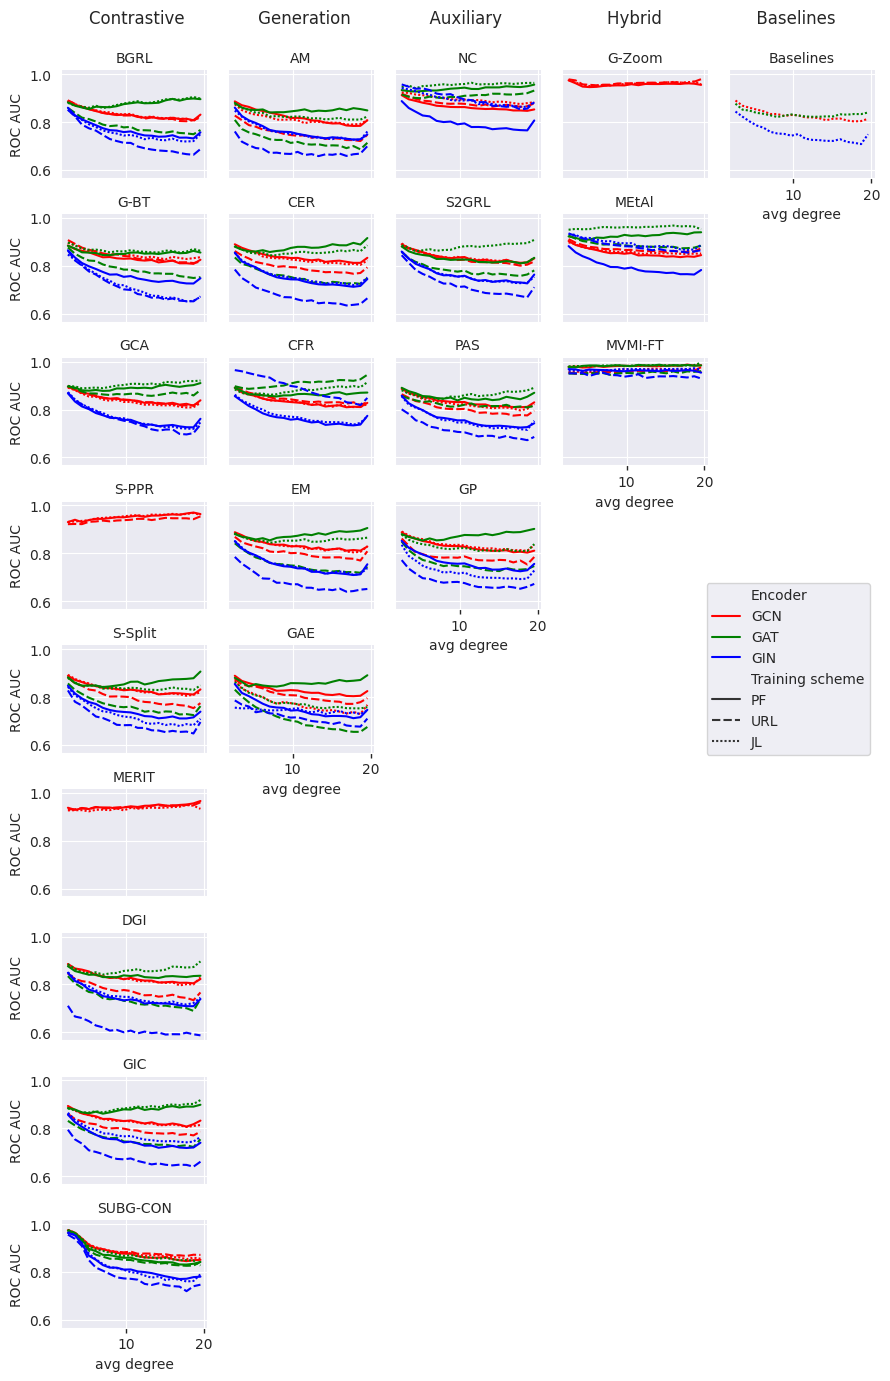

/tmp/ipykernel_34217/3650956971.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[i].set_xticklabels(xticklabels, visible=True)


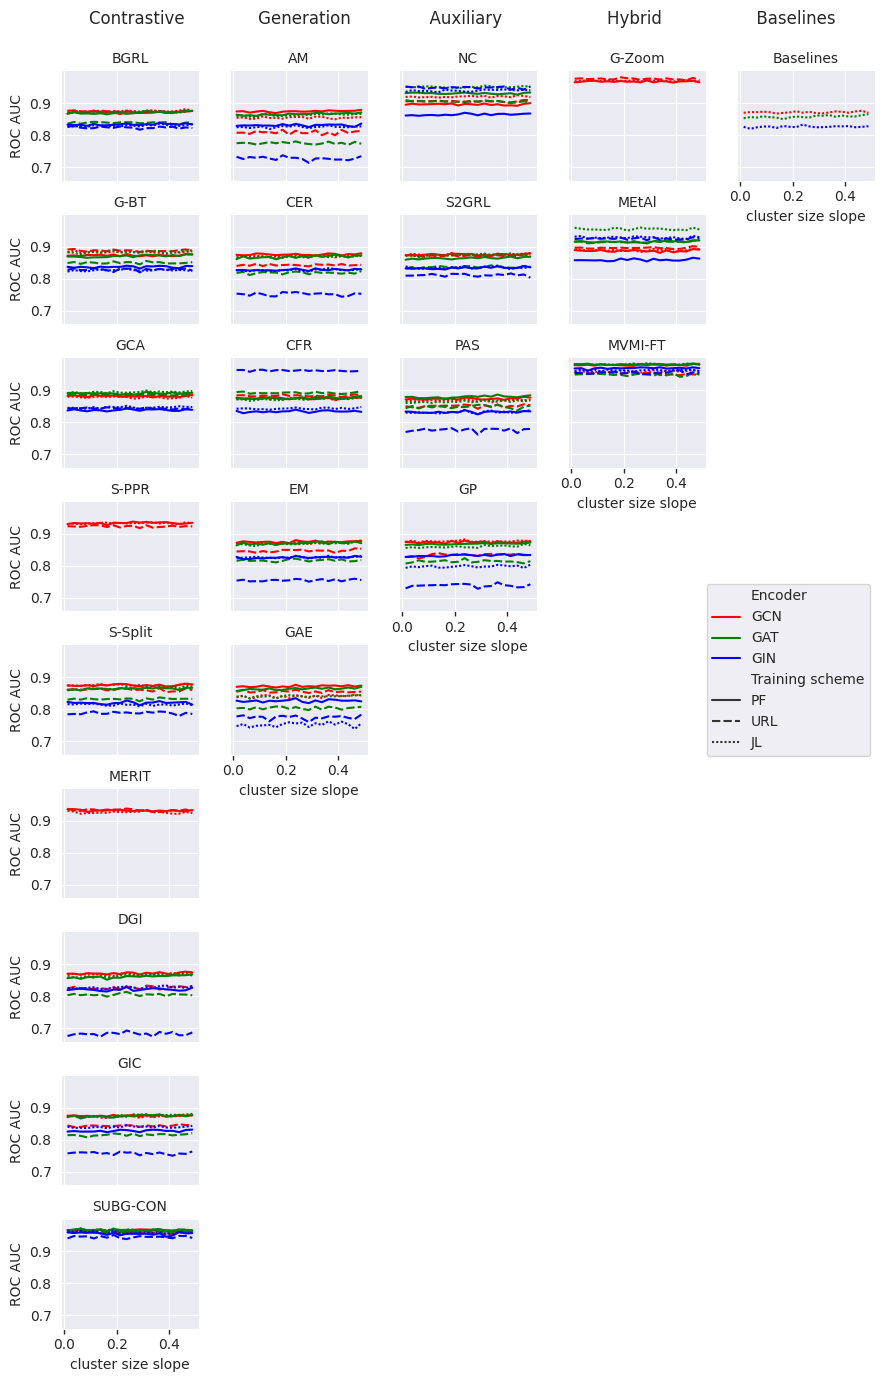

/tmp/ipykernel_34217/3650956971.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[i].set_xticklabels(xticklabels, visible=True)


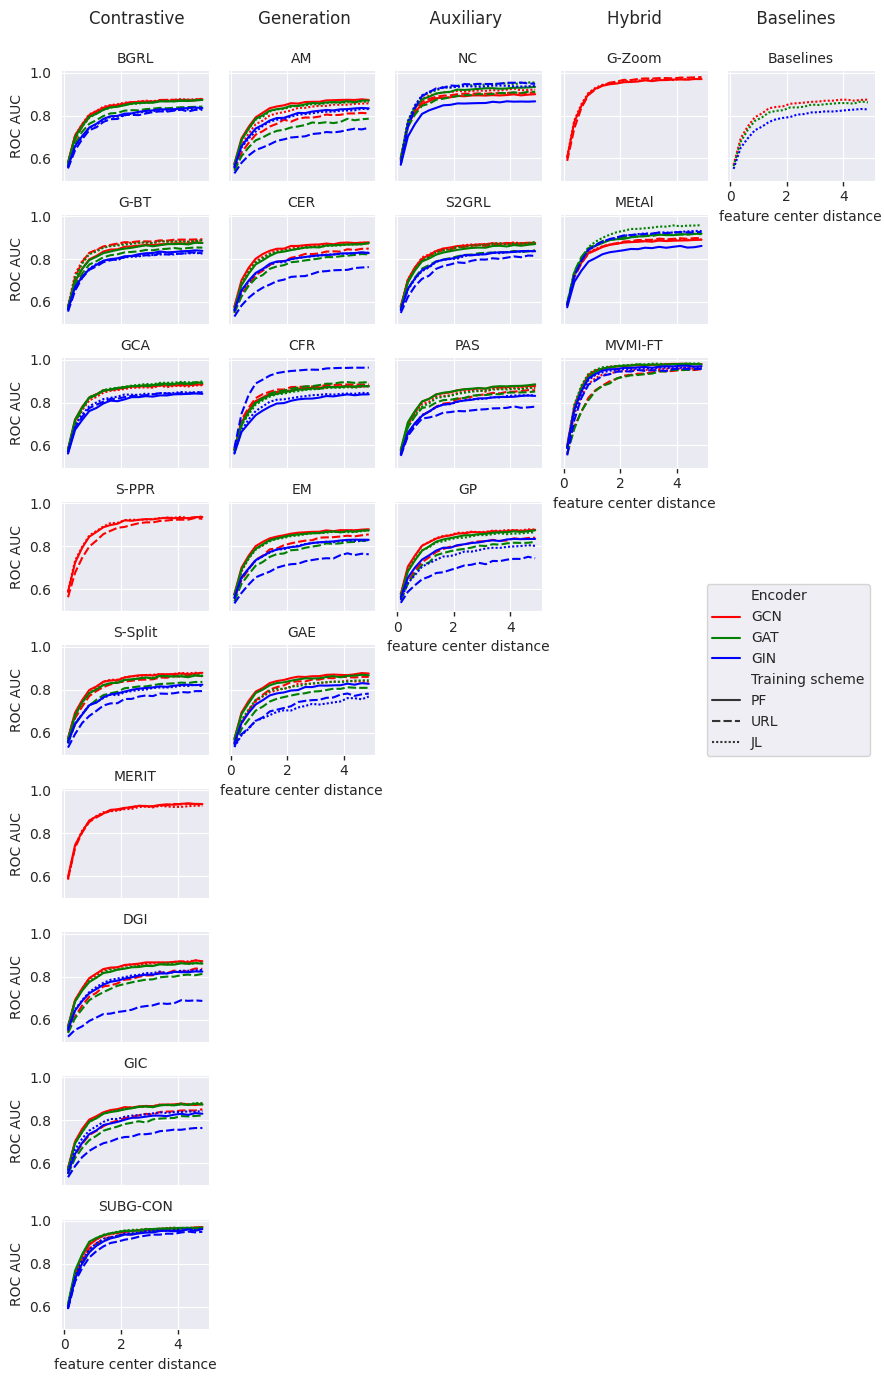

/tmp/ipykernel_34217/3650956971.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[i].set_xticklabels(xticklabels, visible=True)


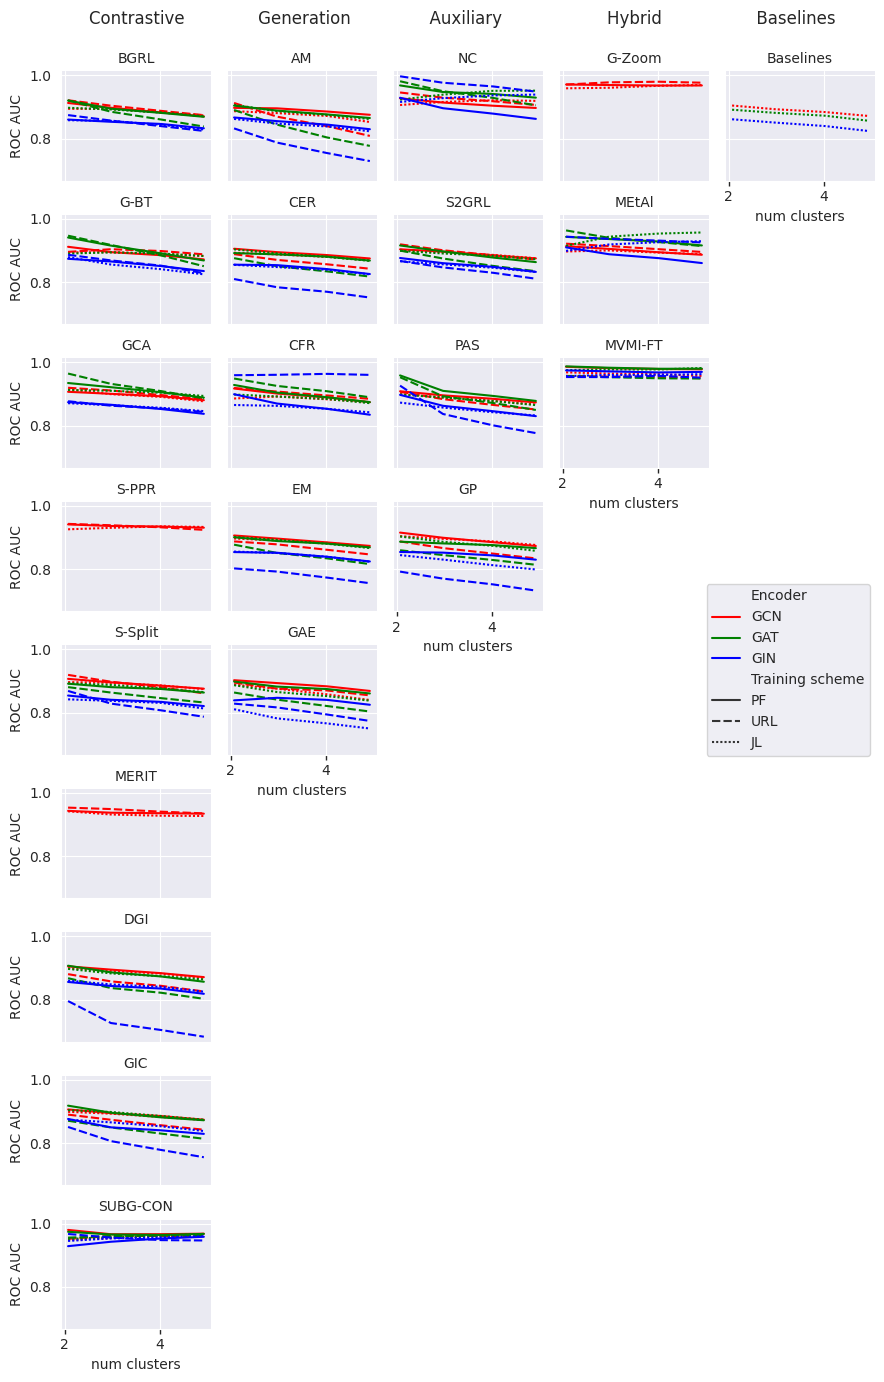

/tmp/ipykernel_34217/3650956971.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[i].set_xticklabels(xticklabels, visible=True)


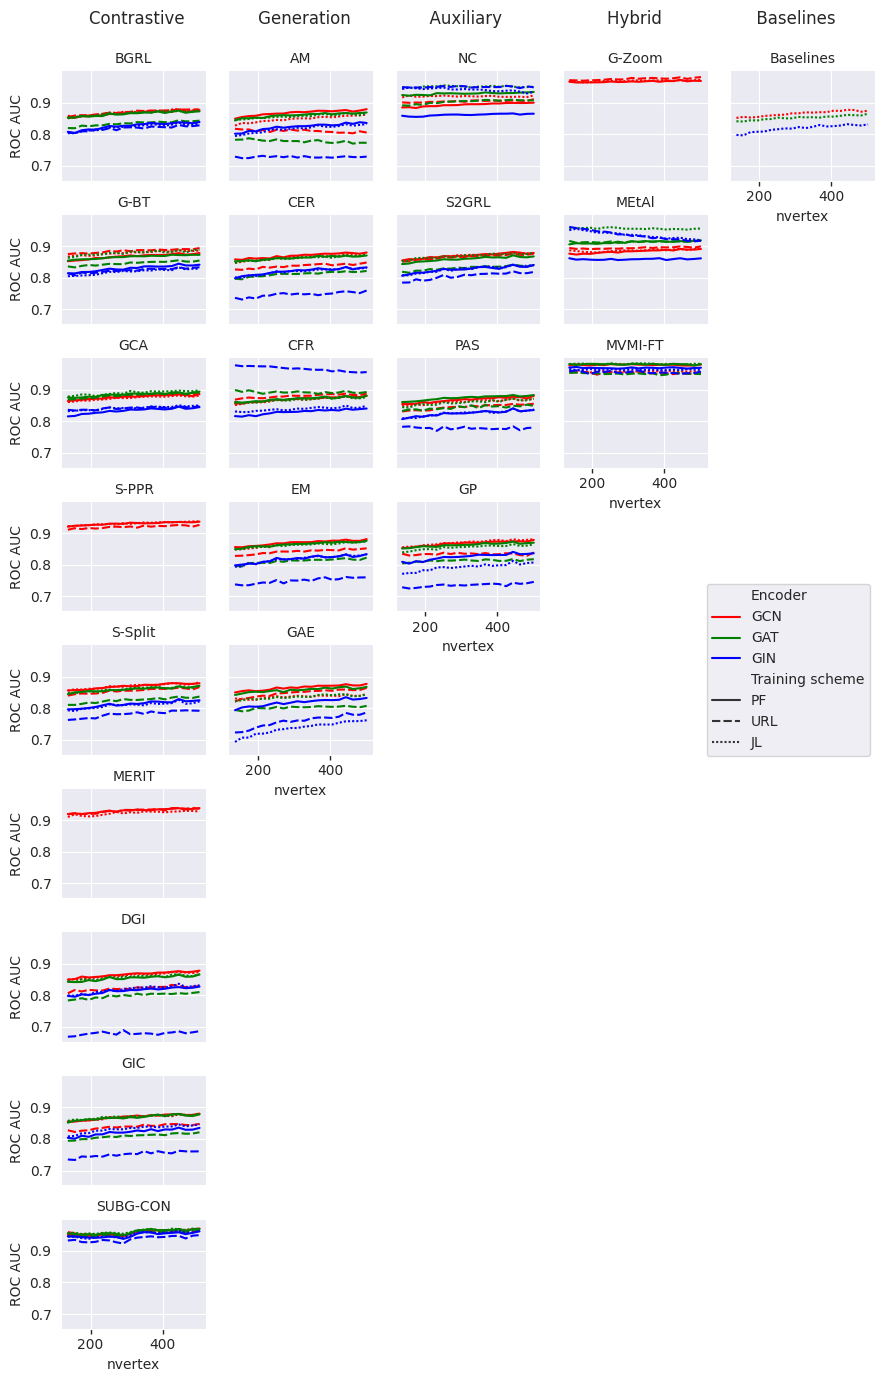

/tmp/ipykernel_34217/3650956971.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[i].set_xticklabels(xticklabels, visible=True)


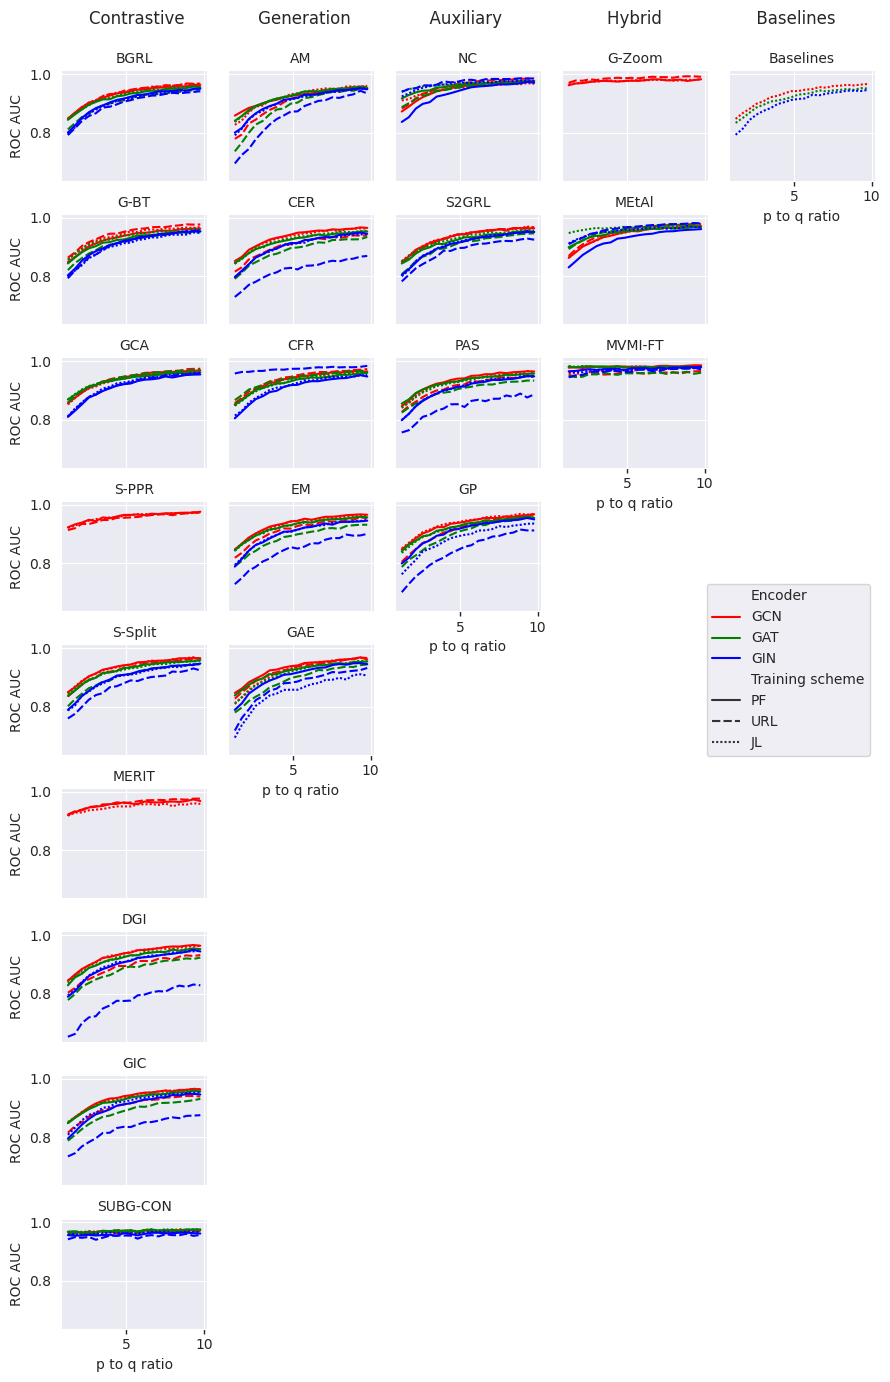

/tmp/ipykernel_34217/3650956971.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[i].set_xticklabels(xticklabels, visible=True)


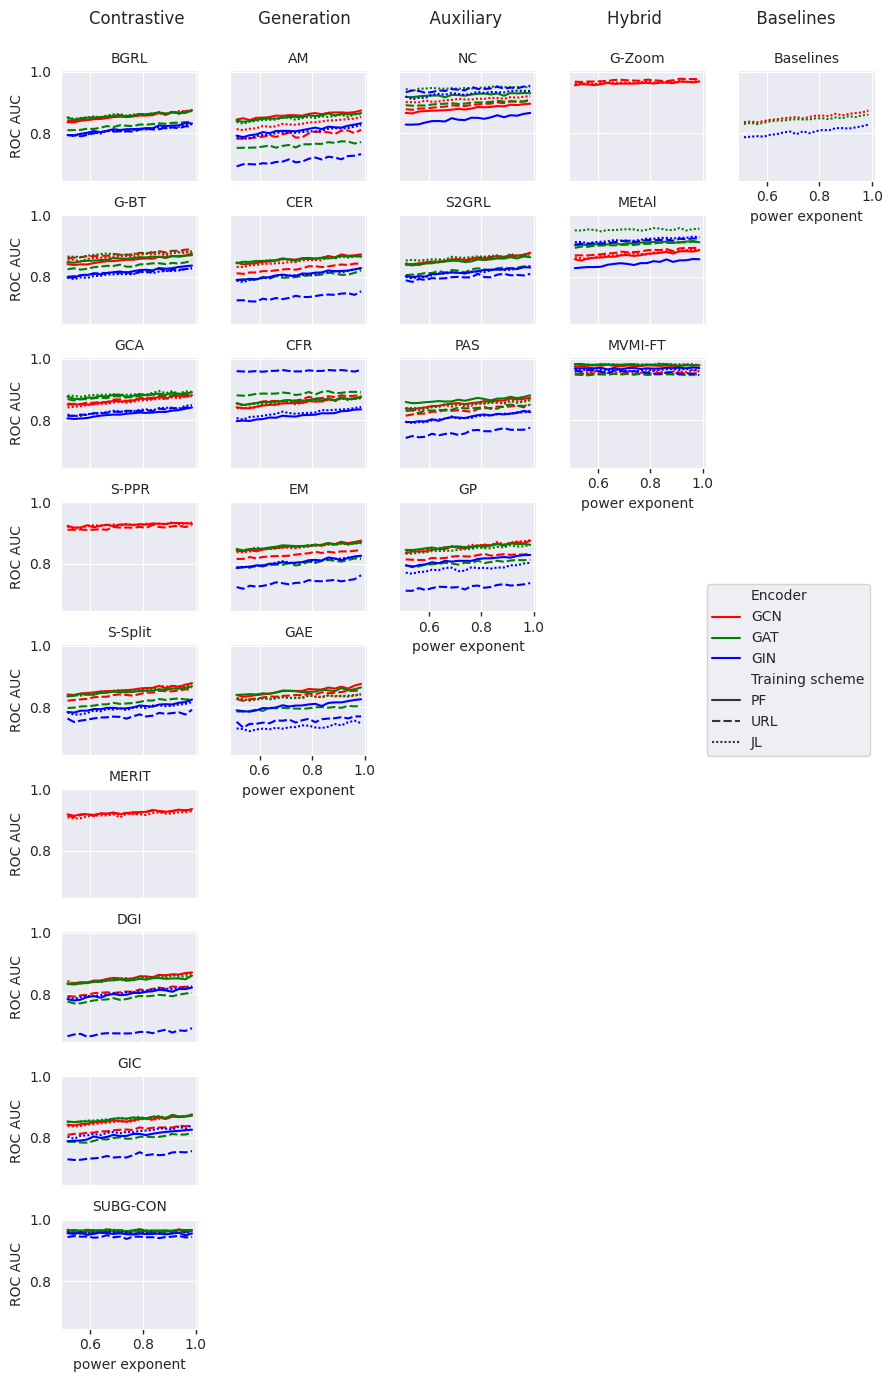

In [36]:
# Construct plotting dataframe
df_baseline['SSL_model'] = "Baselines"
df_baseline['Training_scheme'] = "JL"
df_baseline = df_baseline.rename(columns={"Baseline_model": "Encoder"})
df_plot = pd.concat([df_ssl, df_baseline], ignore_index=True)
df_plot.rename(columns={TEST_METRIC: "ROC AUC"}, inplace=True)
df_plot.rename(columns=lambda x: x.replace('_', ' '), inplace=True)
df_plot['SSL model'] = df_plot['SSL model'].apply(lambda x: x if x == "Baselines" else model_abbreviations[x])

# Styling
markers={'PF':'o', 'URL':'s', 'JL':'X'}
sns.set_style("darkgrid")

# Function to correct the titles made by seaborn
def set_custom_titles(**kwargs):
    title = kwargs['facet'].name.split("=")[-1]
    plt.gca().set_title(title)


# Hack to display the grid of plots such that each column is an SSL category
order = []
rows = len(CONTRAST_ALL)
for (c,g,a,h,b) in zip_longest(CONTRAST_ALL, GENERATION_ALL, AUXILIARY_ALL,  HYBRID_ALL, ["Baselines"], fillvalue="empty"):
    order.append(model_abbreviations.get(c)); order.append(model_abbreviations.get(g)) 
    order.append(model_abbreviations.get(a)); order.append(model_abbreviations.get(h))
    order.append(b)

# Make a plot for each graph parameter
for param, param_group in df_plot.groupby(df_plot['marginal param'].apply(tuple)):
    if len(param) > 1 or param[0] == "min_degree": # Discard two-param marginalization + incorrect configuration for min degree
        continue
    param = param[0].replace("_", " ")
    param_group[param] = pd.cut(param_group[param], bins=20, duplicates='drop').apply(lambda x: x.mid)
    g = sns.relplot(
        data=param_group, x=param, y="ROC AUC",
        col="SSL model", hue="Encoder", style="Training scheme", col_wrap=5, height=1.5, aspect=1.2,
        kind="line", markers=None, dashes=True, errorbar=None, col_order=order, palette=ENCODER_COLORS, 
    )
    g.set_titles("{col_name}") 

    # Correct the xlabel positions based on the empty plots
    xlabel = g.axes[40].get_xlabel()
    xticklabels = g.axes[40].get_xticklabels()
    for i in [4, 13, 17, 21, 40]:
        g.axes[i].set_xlabel(xlabel, visible=True)
        g.axes[i].set_xticklabels(xticklabels, visible=True)
        g.axes[i].tick_params(axis='x', which='both', bottom=True, top=False, width=0)
        g.axes[i].get_xaxis().set_ticks_position('bottom')
        g.axes[i].get_xaxis().set_tick_params(which='both', width=1)

    # Set empty plots invisible
    for (i,j,k), data in g.facet_data():
        if data.empty:
            ax = g.facet_axis(i, j)
            ax.set_axis_off()
            ax.set_title("")

    sns.move_legend(g, "upper left", bbox_to_anchor=(.69, .6), frameon=True)
    plt.suptitle("Contrastive              Generation               Auxiliary                    Hybrid                  Baselines", 
                 y=1.02, x = 0.1, horizontalalignment='left')
    plt.show()

## Main plots with embeddings

In [141]:
def get_embeddings_df(res_dir):
    df_temp = read_processed_shards(join(RESULTS_ROOT, res_dir, 'processed'))
    df_embeddings = unpivot_ssl_model(df=df_temp, suffix=TEST_METRIC, ssl_models=SSL_MODELS, encoders=ENCODERS, 
                                                 training_schemes=TRAINING_SCHEMES,  include_graph_params=True, include_embeddings=True)

    frames  = []
    for index, row in df_embeddings.iterrows():
        df_temp = pd.DataFrame()
        tsne = TSNE(n_components=2, verbose=0, perplexity=10, learning_rate='auto', init='pca')
        tsne_results = tsne.fit_transform(np.array(row['embeddings']))
        df_temp['x1'] = tsne_results[:,0]
        df_temp['x2'] = tsne_results[:,1]
        df_temp['SSL model'] = row['SSL_model']
        df_temp['classes'] = np.array(row['classes'])
        df_temp['Encoder'] = row['Encoder']
        df_temp['Training scheme'] = row['Training_scheme']
        df_temp['avg degree'] = row['avg_degree']
        df_temp['ROC AUC'] = row['test_rocauc_ovr']
        frames.append(df_temp)

    return pd.concat(frames, ignore_index=True)

In [142]:
def plot_marginalization_with_embeddings(df_marg, df_embed, param, filter_e_ts=[("GAT", "URL")], remove_embed_values=[]):
    df_marg_plot = df_marg.copy()
    df_marg_plot = df_marg_plot.sort_values(by=['Encoder', 'Training scheme'])
    df_embed_plot = df_embed.copy()
    df_embed_plot = df_embed_plot.sort_values(by=['Encoder', 'Training scheme'])

    df_marg_plot[param] = pd.cut(df_marg_plot[param], bins=20, duplicates='drop').apply(lambda x: x.mid)
    with sns.axes_style("darkgrid"):
        ax = sns.lineplot(data=df_marg_plot, x=param, y='ROC AUC', hue=df_marg_plot['Encoder'], style='Training scheme',
                    markers=None, dashes=True, errorbar=None, palette=ENCODER_COLORS)
    for i, (e_ts_name, e_ts_group) in enumerate(df_embed.groupby(['Encoder', 'Training scheme'])):
        if e_ts_name not in filter_e_ts:
            continue
        for j, (param_value, param_group) in enumerate(e_ts_group.groupby(param)):
            if j in remove_embed_values:
                continue
            lines = ax.get_lines()
            closest_index = (np.abs(lines[i].get_xdata() - param_value)).argmin()
            x_val = lines[i].get_xdata()[closest_index]
            y_val = lines[i].get_ydata()[closest_index]

            width = (ax.get_xlim()[1] - ax.get_xlim()[0])/15
            height = (ax.get_ylim()[1] - ax.get_ylim()[0])/10
            ax2 = ax.inset_axes([x_val-0.5*width, y_val-0.5*height, (ax.get_xlim()[1] - ax.get_xlim()[0])/10, (ax.get_ylim()[1] - ax.get_ylim()[0])/10],
                            transform=ax.transData)
            ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_xlabel(""); ax2.set_ylabel("")


            with sns.axes_style("white"):
                sns.scatterplot(data=param_group, x='x1', y='x2', hue='classes', legend=False, s=2,
                                palette = sns.color_palette("hls", len(param_group['classes'].unique())), ax=ax2)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()


In [143]:
df_marg = df_plot[df_plot['SSL model'] == "CFR"]
df_embed = get_embeddings_df('embeddings_CFR_avg_degree')

1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
8.ndjson
9.ndjson
10.ndjson
concatenating


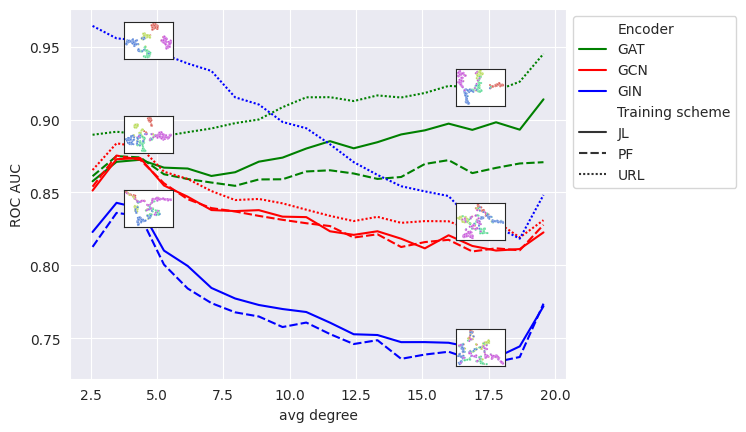

In [148]:
plot_marginalization_with_embeddings(df_marg = df_marg, df_embed = df_embed, param = "avg degree", 
                                     filter_e_ts=[("GAT", "URL"), ("GIN", "URL"), ("GIN", "JL")], remove_embed_values=[0,2,3,4,5,6,7,8])

In [ ]:
for avg_degree, avg_degree_group in plotting_df.groupby(['avg_degree']):
    g = sns.relplot(
            data=avg_degree_group, x='x1', y="x2",
            col="encoder_ts", hue='classes', col_wrap=3, height=2, aspect=1.2,
            kind="scatter", palette = sns.color_palette("hls", len(np.unique(plotting_df['classes'].unique())))
        )
    plt.suptitle(avg_degree, y=1.05)
    plt.show()

## Specific plots for main report